# Gym Activity Analysis

### Importing libraries and tweaking global settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

### Import raw data, display basic information

In [2]:
df_checkin = pd.read_csv('/kaggle/input/gym-check-ins-and-user-metadata/checkin_checkout_history_updated.csv')
df_gym = pd.read_csv('/kaggle/input/gym-check-ins-and-user-metadata/gym_locations_data.csv')
df_sub = pd.read_csv('/kaggle/input/gym-check-ins-and-user-metadata/subscription_plans.csv')
df_user = pd.read_csv('/kaggle/input/gym-check-ins-and-user-metadata/users_data.csv')

print("Check-in Dimensions: ",df_checkin.shape)
print(df_checkin.dtypes)
print("\nGym Dimensions: ",df_gym.shape)
print(df_gym.dtypes)
print("\nSubscription Dimensions: ",df_sub.shape)
print(df_sub.dtypes)
print("\nUser Dimensions: ",df_user.shape)
print(df_user.dtypes)

Check-in Dimensions:  (300000, 6)
user_id            object
gym_id             object
checkin_time       object
checkout_time      object
workout_type       object
calories_burned     int64
dtype: object

Gym Dimensions:  (10, 4)
gym_id        object
location      object
gym_type      object
facilities    object
dtype: object

Subscription Dimensions:  (3, 3)
subscription_plan     object
price_per_month      float64
features              object
dtype: object

User Dimensions:  (5000, 9)
user_id              object
first_name           object
last_name            object
age                   int64
gender               object
birthdate            object
sign_up_date         object
user_location        object
subscription_plan    object
dtype: object


## Data Cleaning

My first order of business in cleaning this data, and to make the cleaning process easier, is going to be to join the data to create one single dataframe with only the columns I plan to make use of.

In particular, the heirarchy of the data starts with the check-in data, then breaks out into users and gyms with the user_id and gym_id respectively, with users branching out into subscription plans through the subscription_plan foreign key.

In [3]:
# Splitting the facilities column into boolean columns that can be better parsed for analysis

# Getting list of unique facilities
flist = sorted(set(df_gym['facilities'].str.split(',').explode().str.strip()))

# Create a new column for each facility, checking if the facility is in each row
for f in flist:
    df_gym[f] = df_gym['facilities'].str.contains(f, case=False, na=False)

In [4]:
# Joining all of the data
df = pd.merge(pd.merge(df_checkin,pd.merge(df_user,df_sub,on=['subscription_plan']),on=['user_id']),df_gym,on=['gym_id'])

# Convert data types
df['checkin_time']=pd.to_datetime(df['checkin_time'])
df['checkout_time']=pd.to_datetime(df['checkout_time'])
df['sign_up_date']=pd.to_datetime(df['sign_up_date'])

# Creating a few columns for future analysis
df['time_spent_min']=((df['checkout_time']-df['checkin_time']).dt.total_seconds()/60).astype(int)
df['hour_of_day']=df['checkin_time'].dt.hour
df['day_of_week'] = df['checkin_time'].dt.day_name()
df['month_of_year']=df['checkin_time'].dt.month_name()

# Removing unnecessary columns
df = df.drop(['user_id','gym_id','checkout_time','first_name','last_name','gender','birthdate','features','facilities','location'],axis=1)

print(df.dtypes)

checkin_time         datetime64[ns]
workout_type                 object
calories_burned               int64
age                           int64
sign_up_date         datetime64[ns]
user_location                object
subscription_plan            object
price_per_month             float64
gym_type                     object
Basketball Court               bool
Climbing Wall                  bool
CrossFit                       bool
Sauna                          bool
Swimming Pool                  bool
Yoga Classes                   bool
time_spent_min                int64
hour_of_day                   int32
day_of_week                  object
month_of_year                object
dtype: object


In [5]:
# Creating a conditional column to separate age brackets

conditions = [
    (df['age']<25),
    (df['age']>=25) & (df['age']<35),
    (df['age']>=35) & (df['age']<45),
    (df['age']>=45) & (df['age']<55),
    (df['age']>=55)
]
choices = ['18-24','25-34','35-44','45-54','55+']
# This line will create a conditional column using my previously defined conditions, and their corresponding choice outcomes:
df['Age_Bracket'] = np.select(conditions,choices,default=0)

In [6]:
# Fix new column names to be consistent
new_cols = {'Basketball Court':'basketball_court',
           'Climbing Wall':'climbing_wall',
           'CrossFit':'crossfit',
           'Sauna':'sauna',
           'Swimming Pool':'swimming_pool',
           'Yoga Classes':'yoga_classes'}
df = df.rename(new_cols,axis=1)

checkin_time         0
workout_type         0
calories_burned      0
age                  0
sign_up_date         0
user_location        0
subscription_plan    0
price_per_month      0
gym_type             0
basketball_court     0
climbing_wall        0
crossfit             0
sauna                0
swimming_pool        0
yoga_classes         0
time_spent_min       0
hour_of_day          0
day_of_week          0
month_of_year        0
Age_Bracket          0
dtype: int64


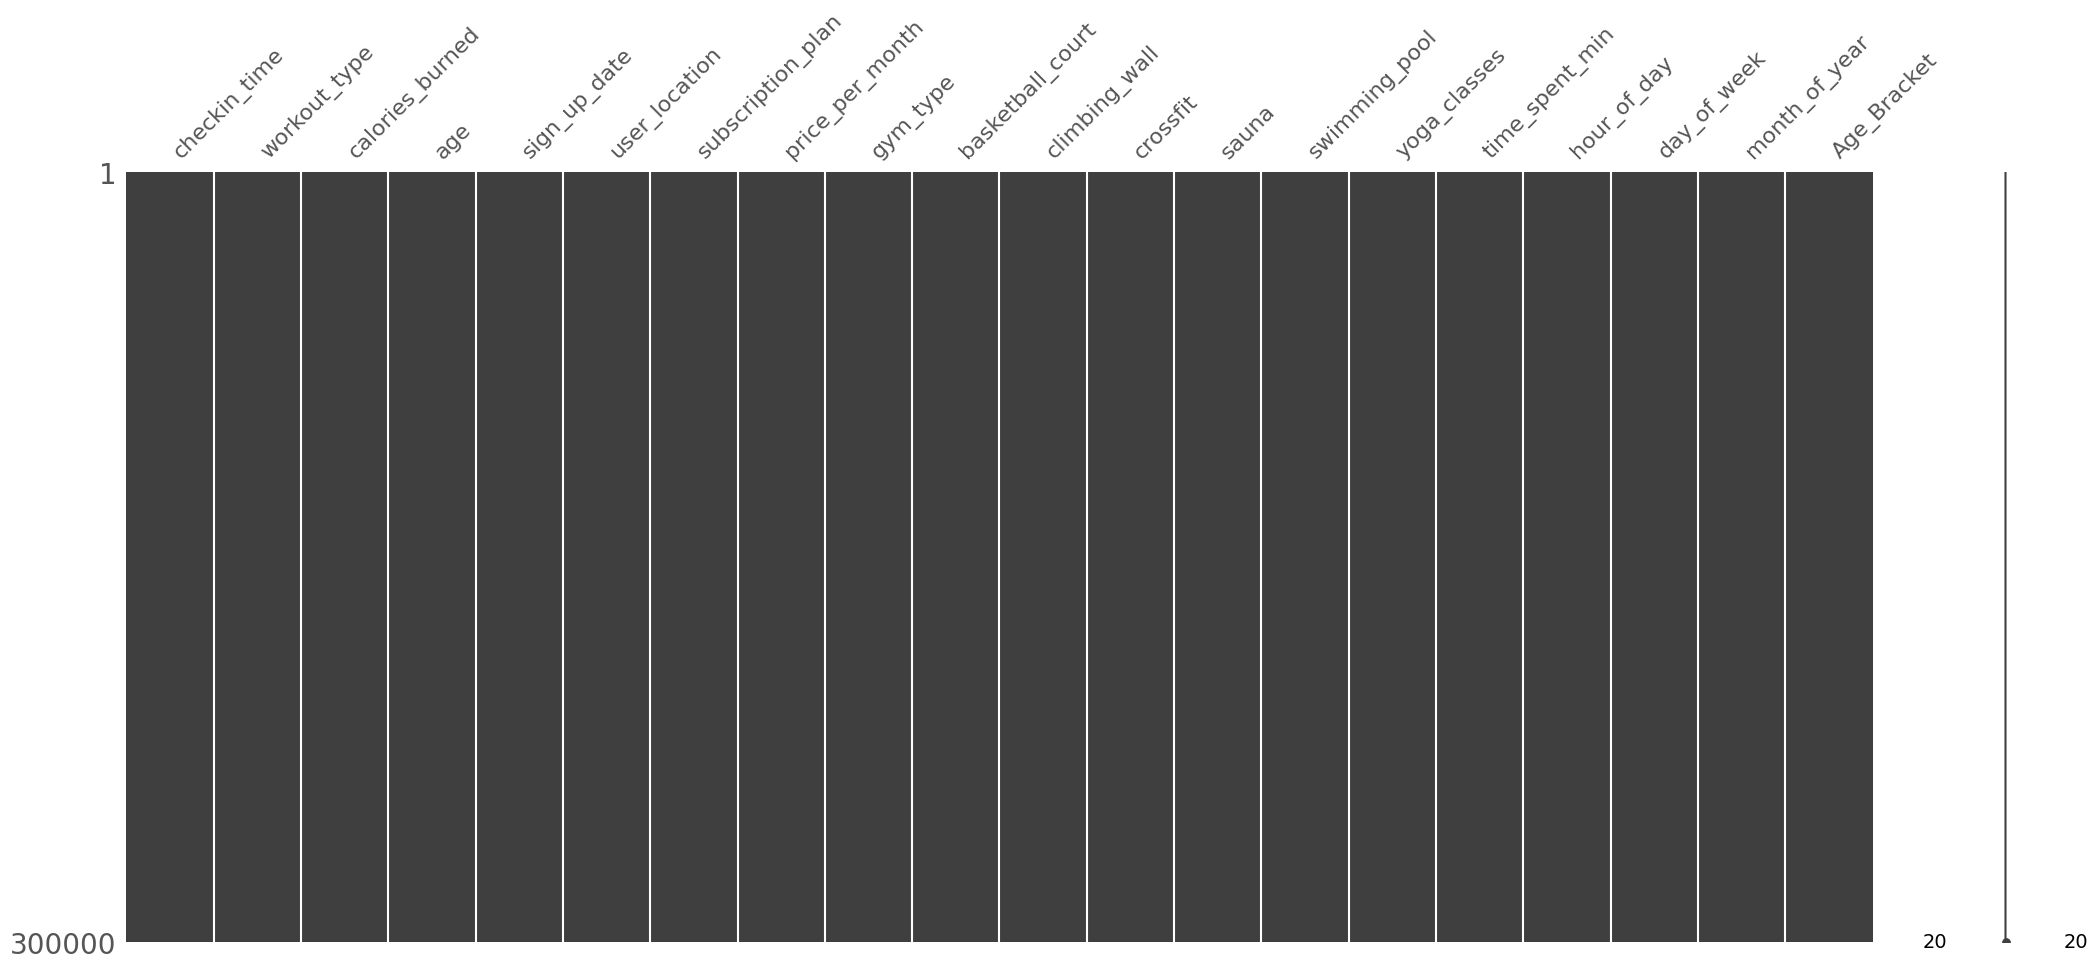

In [7]:
# Checking for missing values
print(df.isna().sum())
msno.matrix(df)
plt.show()

In [8]:
# Checking for duplicate values
df = df.loc[~df.duplicated()].reset_index(drop=True).copy()
df.loc[df.duplicated()]

,checkin_time,workout_type,calories_burned,age,sign_up_date,user_location,subscription_plan,price_per_month,gym_type,basketball_court,climbing_wall,crossfit,sauna,swimming_pool,yoga_classes,time_spent_min,hour_of_day,day_of_week,month_of_year,Age_Bracket


Looking at cleaned dataframe:

In [9]:
print(df.shape)
print(df.describe())
df.head()

(300000, 20)
                        checkin_time  calories_burned         age  \
count                         300000      300000.0000 300000.0000   
mean   2023-05-24 22:28:25.092799744         886.0887     41.2169   
min              2023-01-01 06:00:00         150.0000     18.0000   
25%              2023-03-14 08:35:45         534.0000     30.0000   
50%              2023-05-24 17:31:00         834.0000     41.0000   
75%              2023-08-04 14:43:15        1179.0000     53.0000   
max              2023-10-15 20:59:00        2147.0000     64.0000   
std                              NaN         432.6954     13.5385   

                        sign_up_date  price_per_month  time_spent_min  \
count                         300000      300000.0000     300000.0000   
mean   2022-05-25 09:48:58.752000256          26.7308        104.5196   
min              2021-01-01 00:00:00           9.9900         30.0000   
25%              2021-09-15 00:00:00           9.9900         67.0000   


,checkin_time,workout_type,calories_burned,age,sign_up_date,user_location,subscription_plan,price_per_month,gym_type,basketball_court,climbing_wall,crossfit,sauna,swimming_pool,yoga_classes,time_spent_min,hour_of_day,day_of_week,month_of_year,Age_Bracket
0,2023-09-10 15:55:00,Weightlifting,462,41,2023-04-08,Atlanta,Pro,49.9900,Budget,False,True,False,True,True,False,39,15,Sunday,September,35-44
1,2023-04-13 20:07:00,Yoga,1278,24,2023-07-16,Las Vegas,Pro,49.9900,Budget,False,True,False,True,False,True,156,20,Thursday,April,18-24
2,2023-06-10 12:24:00,Cardio,858,37,2021-09-15,Boston,Basic,19.9900,Premium,True,False,False,True,True,False,85,12,Saturday,June,35-44
3,2023-05-23 17:11:00,Yoga,1134,34,2023-04-25,Las Vegas,Student,9.9900,Budget,False,True,False,True,False,True,170,17,Tuesday,May,25-34
4,2023-02-21 06:20:00,Weightlifting,1049,32,2022-12-29,Austin,Pro,49.9900,Premium,False,False,True,True,True,False,102,6,Tuesday,February,25-34


## Data Analysis

Among other goals of this analysis, I would like to start by determining the best times for gym activity:

In [10]:
# This function is not too important, and serves the purpose of making the upcoming visuals easier to interpret with automatically adjusting data labels
def shortnum(num):
    if num>=1000000:
        return f'{num/1000000:.1f}M'
    elif num>=1000:
        return f'{num/1000:.1f}K'
    else:
        return num.asstring()

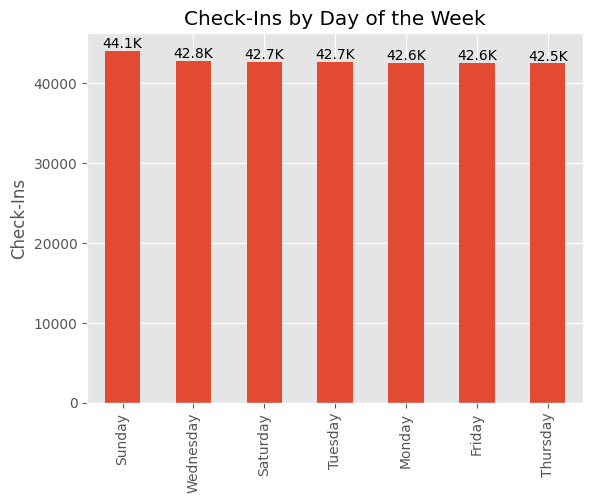

In [11]:
# Looking at gym interactions broken up by day of the week

# Create a new dataframe aggregated by day of the week
df_dow = df.groupby('day_of_week').size().reset_index(name='count').sort_values(by='count',ascending=False)

# Plot the new dataframe
ax = df_dow.plot(x='day_of_week',y='count',kind='bar',title='Check-Ins by Day of the Week',legend=False)

# Apply data labels
for i in ax.patches:
    ax.text(i.get_x()+i.get_width()/2, i.get_height(), shortnum(i.get_height()), ha='center', va='bottom', fontsize=10)

ax.set_xlabel('')
ax.set_ylabel('Check-Ins')
plt.show()

This plot does not seem to show any notable trend, next I will look at months of the year:

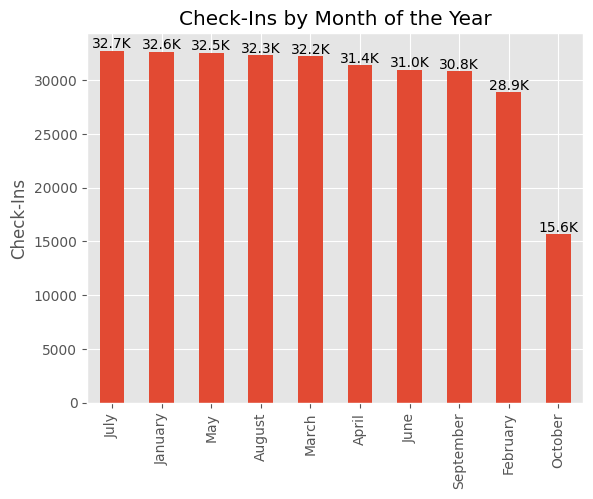

In [12]:
# Looking at gym interactions broken up by month of the year

# Create a new dataframe aggregated by month of the year
df_dow = df.groupby('month_of_year').size().reset_index(name='count').sort_values(by='count',ascending=False)

# Plot the new dataframe
ax = df_dow.plot(x='month_of_year',y='count',kind='bar',title='Check-Ins by Month of the Year',legend=False)

# Apply data labels
for i in ax.patches:
    ax.text(i.get_x()+i.get_width()/2, i.get_height(), shortnum(i.get_height()), ha='center', va='bottom', fontsize=10)

ax.set_xlabel('')
ax.set_ylabel('Check-Ins')
plt.show()

Like before, there is not much notable trend other than one month with significantly less action that could be due to having less data, or some other reason.

Now I will take a look at the best hours of the day for gym-goers:

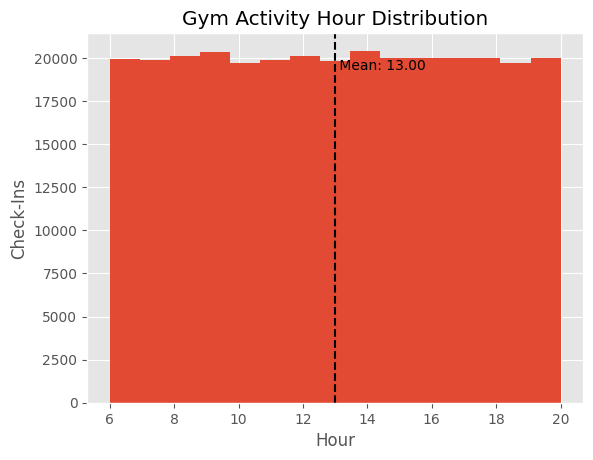

In [13]:
# Begin Analysis by looking at a summary of critical numeric columns

# Looking for the hour of day that prompts the highest bikes sales
ax = df['hour_of_day'].plot(kind='hist',bins=15,title='Gym Activity Hour Distribution')
ax.set_xlabel('Hour')
ax.set_ylabel('Check-Ins')

# Adding mean line to graph
mean = df['hour_of_day'].mean()
ax.axvline(mean, color='k', linestyle='--')
ax.text(mean, ax.get_ylim()[1]*0.9, f' Mean: {mean:.2f}', color='k', ha='left')

plt.show()

The best hour of the day for gym activity tends to be pretty even with not much information being obtained from the plot.
Lastly I will plot all time data for interactions on a single line graph:

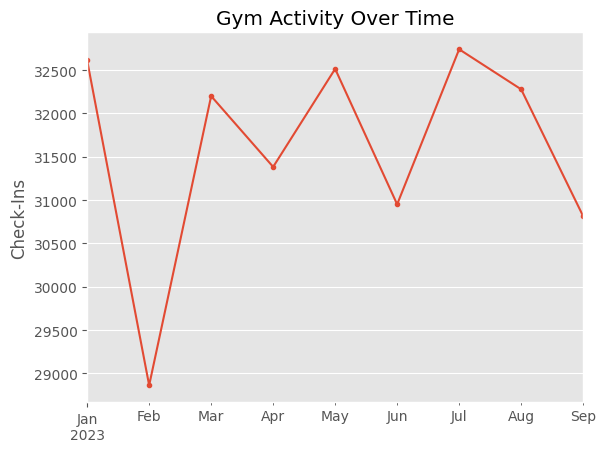

In [14]:
# Set new index to timestamp column to allow data to be regrouped by month to clean the graph
df.set_index('checkin_time', inplace=True, drop=False)

# Resample graph by month instead of datetime to clean up a lot of clutter and create a clean plot
monthly_data = df.resample('ME').size().to_frame(name='checkins')
monthly_data.reset_index(inplace=True)

# Filter data to before October 2023 as it is missing half a month of data
monthly_data = monthly_data[monthly_data['checkin_time'] < '2023-10-01']

# Plot bike sales against time
ax = monthly_data.plot(x='checkin_time',y='checkins',kind='line',style='.-',title='Gym Activity Over Time',legend=False)
ax.set_xlabel('')
ax.set_ylabel('Check-Ins')
plt.show()

From the above plot, check-ins seem to be stagnant over thee past year, with a small dip around february. 

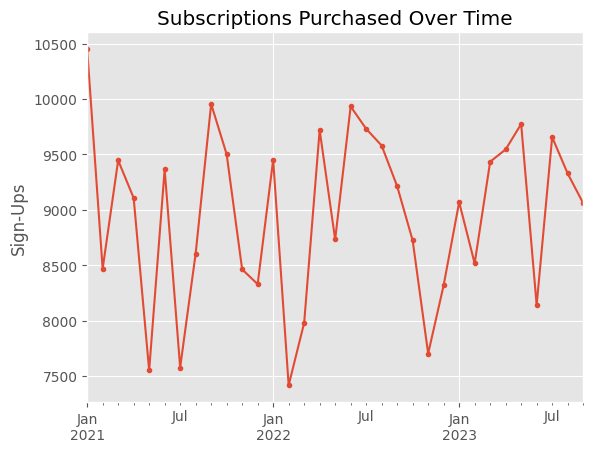

In [15]:
# Set new index to timestamp column to allow data to be regrouped by month to clean the graph
df.set_index('sign_up_date', inplace=True, drop=False)

# Resample graph by month instead of datetime to clean up a lot of clutter and create a clean plot
monthly_data = df.resample('ME').size().to_frame(name='signups')
monthly_data.reset_index(inplace=True)

# Filter data to before October 2023 as it is missing half a month of data
monthly_data = monthly_data[monthly_data['sign_up_date'] < '2023-10-01']

# Plot bike sales against time
ax = monthly_data.plot(x='sign_up_date',y='signups',kind='line',style='.-',title='Subscriptions Purchased Over Time',legend=False)
ax.set_xlabel('')
ax.set_ylabel('Sign-Ups')
plt.show()

From the above plot, the sign-ups appear to start at a max during the opening month, then settle into a cyclic pattern between 8-10k per month over the next 2 years.

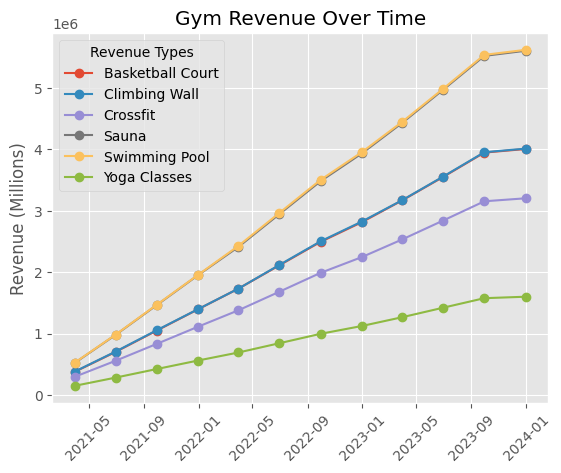

In [50]:
amenities = ['basketball_court','climbing_wall','crossfit','sauna','swimming_pool','yoga_classes']

# Set new index to timestamp column to allow data to be regrouped by month to clean the graph
df.set_index('sign_up_date', inplace=True, drop=False)

# Resample graph by month instead of datetime to clean up a lot of clutter and create a clean plot
monthly_revenue = df.resample('QE')['price_per_month'].sum().to_frame(name='revenue')
monthly_revenue['cumulative_revenue'] = monthly_revenue['revenue'].cumsum()
monthly_revenue.reset_index(inplace=True)

# Filter data to before October 2023 as it is missing half a month of data
monthly_revenue=monthly_revenue[monthly_revenue['sign_up_date'] < '2023-10-01']

# Plot revenue against each amenity
fig, ax = plt.subplots()

for amenity in amenities:
    amenity_df = df[df[amenity] == True]
    
    # Resample by quarter and calculate the total revenue for the amenity
    quarterly_revenue = amenity_df.resample('QE')['price_per_month'].sum().to_frame(name='revenue')
    quarterly_revenue['cumulative_revenue']=quarterly_revenue['revenue'].cumsum()
    quarterly_revenue.reset_index(inplace=True)
    
    # Plot cumulative revenue for this amenity with a unique color and label
    ax.plot(quarterly_revenue['sign_up_date'],quarterly_revenue['cumulative_revenue'],label=f'{amenity.replace("_"," ").title()}',linestyle='-',marker='o')

ax.set_xlabel('')
ax.set_ylabel('Revenue (Millions)')
ax.set_title('Gym Revenue Over Time')
ax.legend(title="Revenue Types")
plt.xticks(rotation=45)
plt.show()

Although it is hard to tell, Sauna and Swimming Pool are essentially overlapping in revenue, as well as Climbing Wall and Basketball Court. This leaves Yoga Classes as the least revenue amenity offered in relevant gyms.

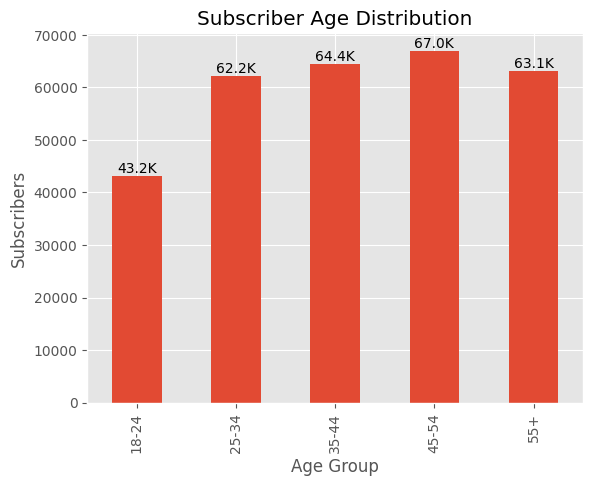

In [16]:
# Looking for the age bracket that yields the most customers
df_Age = df[['Age_Bracket']].groupby('Age_Bracket').agg('size').reset_index().copy()
df_Age.columns = ['Age_Bracket','Subscribers']

ax = df_Age.plot(x='Age_Bracket',y='Subscribers',kind='bar',title='Subscriber Age Distribution',legend=False)
ax.set_xlabel('Age Group')
ax.set_ylabel('Subscribers')

# Apply data labels
for i in ax.patches:
    ax.text(i.get_x() + i.get_width()/2, i.get_height(), shortnum(i.get_height()), ha='center', va='bottom', fontsize=10)

plt.show()

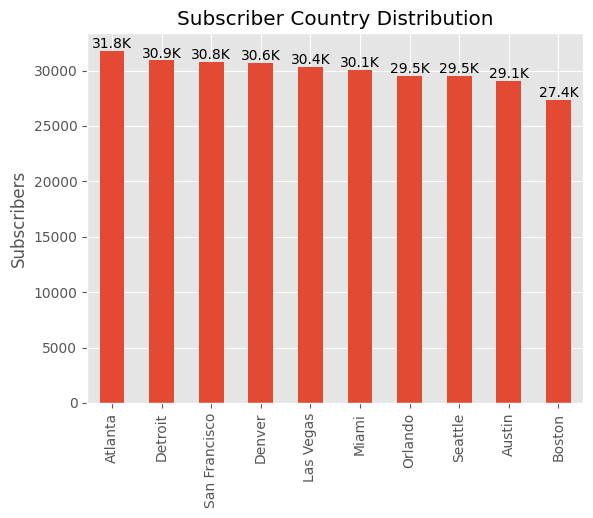

In [17]:
# Looking for the country that yields the most customers
df_Loc = df[['user_location']].groupby('user_location').agg('size').sort_values(ascending=False).reset_index().copy()
df_Loc.columns = ['user_location','Subscribers']

ax = df_Loc.plot(x='user_location',y='Subscribers',kind='bar',title='Subscriber Country Distribution',legend=False)
ax.set_xlabel('')
ax.set_ylabel('Subscribers')

# Apply data labels
for i in ax.patches:
    ax.text(i.get_x() + i.get_width()/2, i.get_height(), shortnum(i.get_height()), ha='center', va='bottom', fontsize=10)

plt.show()

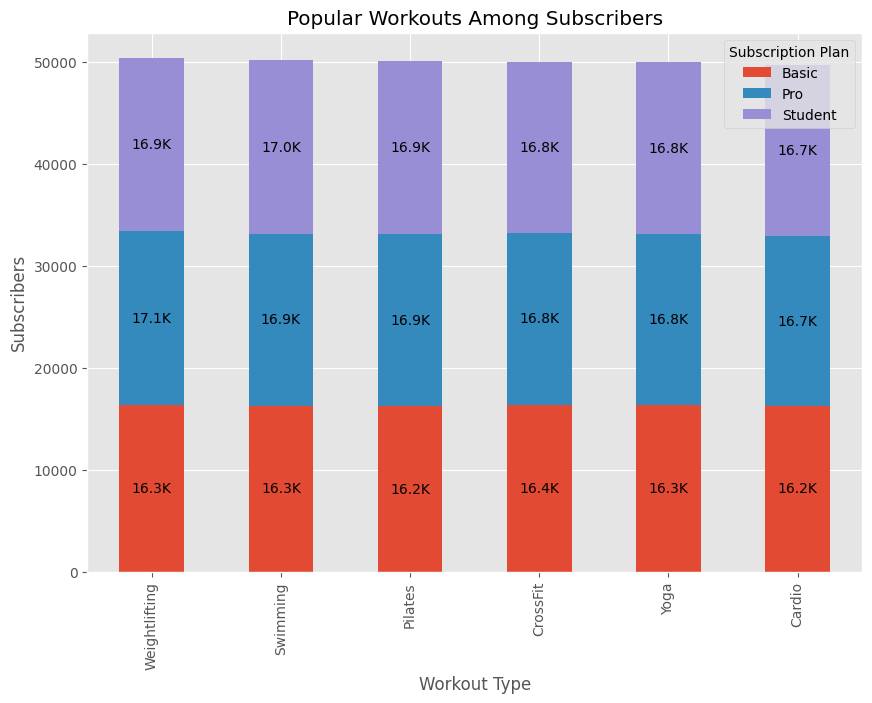

In [25]:
# Looking for the workout type that is most popular to customers

# Group data by workout type and subscription plan, then sort the rows by their additive total
df_temp = df.groupby(['workout_type', 'subscription_plan']).size().unstack()
df_temp['Total'] = df_temp.sum(axis=1)
df_temp = df_temp.sort_values(by='Total', ascending=False).drop('Total', axis=1)

# Plot the stacked bar chart
ax = df_temp.plot(kind='bar', stacked=True, title='Popular Workouts Among Subscribers', figsize=(10, 7))
ax.set_xlabel('Workout Type')
ax.set_ylabel('Subscribers')
ax.legend(title='Subscription Plan')

# Apply data labels on each segment of the stacked bars
for p in ax.patches:
    # Only add a label if the height is greater than zero
    if p.get_height() > 0:
        # Position the label in the middle of the segment
        ax.text(p.get_x() + p.get_width() / 2, p.get_y() + (p.get_height() / 2), 
                shortnum(p.get_height()), ha='center', va='center', fontsize=10)

plt.show()

From the above chart, we can tell that all gym-goers generally prefer an even spread of workouts, with basic plan subscribers preferring CrossFit, pro plan subscribers preferring weightlifting, and student plan subscribers preferring swimming all by a slight interval.

Next, I'd like to take a closer look at any relationships in the data:

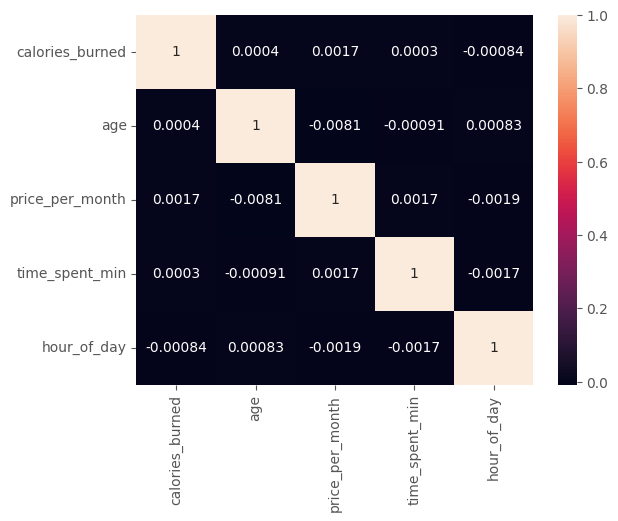

In [51]:
df_corr = df[['calories_burned','age','price_per_month','time_spent_min','hour_of_day']].dropna().corr()
sns.heatmap(df_corr,annot=True)
plt.show()

There does not appear to be any relationships in the data that are worth exploring from a glance.